# Загрузка данных

In [1]:
!wget  'https://disk.skbkontur.ru/index.php/s/aknGb6oZSzA8djG/download' 

--2022-04-19 12:51:34--  https://disk.skbkontur.ru/index.php/s/aknGb6oZSzA8djG/download
Resolving disk.skbkontur.ru (disk.skbkontur.ru)... 46.17.202.21, 46.17.201.85
Connecting to disk.skbkontur.ru (disk.skbkontur.ru)|46.17.202.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264566 (258K) [application/zip]
Saving to: ‘download’

download            100%[===================>] 258.37K   404KB/s    in 0.6s    

2022-04-19 12:51:36 (404 KB/s) - ‘download’ saved [264566/264566]



In [2]:
!ls

download  sample_data


In [3]:
!unzip download

Archive:  download
  inflating: dataset/train.tsv       
  inflating: dataset/test.tsv        
  inflating: task.md                 


In [4]:
!ls dataset

test.tsv  train.tsv


In [5]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv("./dataset/train.tsv", sep='\t')

# Анализ данных

In [7]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

Посмотри на размерности наших данных.

In [8]:
df.shape

(5758, 2)

Посмотрим как выглядит таблица.

In [9]:
df.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


Новости на руссокм языке. Следует правильно выбрать библиотеки.

In [10]:
for i in range(5):
    print(df.title[i])

Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы
Агент Кокорина назвал езду по встречке житейской историей
Госдума рассмотрит возможность введения секретных статей Уголовного кодекса
ФАС заблокировала поставку скоростных трамваев для Москвы
Против Навального завели дело о недоносительстве на Волкова


Классы хорошо сбалансированные.

In [11]:
df.is_fake.value_counts()

1    2879
0    2879
Name: is_fake, dtype: int64

В данных нет пустых значений.

In [12]:
df[df == np.nan].sum()

title        0
is_fake    0.0
dtype: object

In [13]:
df.dropna()
df.shape

(5758, 2)

In [14]:
labels = df.is_fake.copy().to_numpy()

In [15]:
train_data = df.title.copy().to_numpy()

In [16]:
train_data[0]

'Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы'

Импотрируем `nltk` библиотеку для удаления стопслов. И посмотрим, как выглядят стоп слова.

In [17]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords = set(stopwords.words('russian'))
print(stopWords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'другой', 'над', 'же', 'нас', 'опять', 'с', 'ней', 'со', 'чтобы', 'ее', 'нельзя', 'сейчас', 'тебя', 'хорошо', 'них', 'здесь', 'два', 'ему', 'разве', 'через', 'больше', 'ним', 'я', 'почти', 'нет', 'даже', 'они', 'вы', 'такой', 'а', 'эту', 'много', 'ли', 'него', 'потом', 'за', 'перед', 'она', 'себя', 'мне', 'ничего', 'надо', 'мы', 'всех', 'всего', 'наконец', 'том', 'и', 'их', 'до', 'вот', 'будто', 'вас', 'где', 'им', 'уж', 'меня', 'никогда', 'три', 'к', 'мой', 'под', 'лучше', 'тогда', 'все', 'о', 'что', 'про', 'всегда', 'ей', 'по', 'между', 'этого', 'из', 'во', 'или', 'более', 'если', 'ведь', 'там', 'один', 'чтоб', 'при', 'его', 'тем', 'тут', 'для', 'в', 'себе', 'вам', 'ты', 'какой', 'ну', 'ж', 'свою', 'об', 'иногда', 'вдруг', 'какая', 'он', 'было', 'уже', 'у', 'этом', 'быть', 'была', 'кто', 'на', 'как', 'чего', 'чуть', 'так', 'куда', 'без', 'можно', 'еще', 'тот', 'того', 'этой

Напишем свой токинезатор.

In [18]:
import re
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import SnowballStemmer
class MyTokenizerStemming:
    def __init__(self):
        pass
    def tokenize(self, text):
        tokens = re.findall('[А-Яа-яЁё]+', text)
        tokens = [t for t in tokens if t not in stopWords]
        ss = SnowballStemmer(language='russian')
        tokens = ' '.join(list(map(ss.stem, tokens)))
        return tokens
    def get_tokens(self, data):
        result = []
        for i in data:
            result.append(self.tokenize(i))
        return result

Stemming_tokenizer = MyTokenizerStemming()

In [19]:
!pip install -q pymorphy2
import pymorphy2 

     |████████████████████████████████| 55 kB 1.7 MB/s 
     |████████████████████████████████| 8.2 MB 5.4 MB/s 


In [20]:
import re
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
morph = pymorphy2.MorphAnalyzer()
class MyTokenizerLemm:  
    def __init__(self):
        pass
    def tokenize(self, text):
        tokens = re.findall('[ЁёА-Яа-я]+', text)
        tokens = list(map(lambda x: morph.parse(x)[0].normal_form, tokens))
        tokens = ' '.join([t for t in tokens if t not in stopWords])
        return tokens
    def get_tokens(self, data):
        result = []
        for i in data:
            result.append(self.tokenize(i))
        return result

Lemm_tokenizer = MyTokenizerLemm()

In [21]:
Stemming_tokenizer.get_tokens(["ёжики вышли на прогулку"]), Lemm_tokenizer.get_tokens(["ёжики вышли на прогулку"])

(['ежик вышл прогулк'], ['ёжик выйти прогулка'])

Посмотри на результат.

In [22]:
Stemming_tokenizer.get_tokens(train_data[12:17])

['в росс введут обязательн техосмотр садов инвентар',
 'топилин провозглас окончан зарплатн кризис росс',
 'режиссер алексе герма наград орден',
 'олаф шольц дед рассказыва как вкусн украин кур молок яйц',
 'бегл петербург основа наш эр полтор тысяч лет старш москв']

In [23]:
 Lemm_tokenizer.get_tokens(train_data[12:17])

['россия ввести обязательный техосмотр садовый инвентарь',
 'топилина провозгласить окончание зарплатный кризис россия',
 'режиссёр алексей герман наградить орден',
 'олафа шольц дед рассказывать вкусный украина кура молоко яйцо',
 'беглов петербург основать наш эра полтора тысяча год старший москва']

Токинезируем данные.

In [24]:
corpus = Stemming_tokenizer.get_tokens(train_data)

In [25]:
corpus[:5]

['москвич владимир клутин пришел счет вмешательств американск выбор',
 'агент кокорин назва езд встречк житейск истор',
 'госдум рассмотр возможн введен секретн стат уголовн кодекс',
 'фас заблокирова поставк скоростн трамва москв',
 'прот навальн завел дел недоносительств волков']

Для начала используем TF-IDF метрику для перевода новостей в численные признаки.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_v=TfidfVectorizer(max_features=7500,ngram_range=(1,3))
X = tfidf_v.fit_transform(corpus).toarray()

In [27]:
X.shape

(5758, 7500)

Разделим данные на тестовую и обучающую части.

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

Посмотри какие признаки выделила TF-IDF.

In [29]:
tfidf_v.get_feature_names_out()[:10]

array(['аборт', 'абрамович', 'авангард', 'авар', 'аварийн', 'август',
       'авиабилет', 'авиакомпан', 'авиакомпан белав', 'авиалин'],
      dtype=object)

In [30]:
tfidf_v.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 7500,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [31]:
count_df = pd.DataFrame(X_train, columns=tfidf_v.get_feature_names())
count_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,аборт,абрамович,авангард,авар,аварийн,август,авиабилет,авиакомпан,авиакомпан белав,авиалин,...,янукович,япон,япон нача,японск,ярмарк,яров,яров потребова,ярославл,ярославск,яхт
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Так выглядит наша матрица после преобразования TF-IDF.

In [32]:
from sklearn import metrics
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Попробуем разные модели классификаторы.

# MultinomialNB Algorithm

In [34]:
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()

f1-score:   0.850
Confusion matrix, without normalization


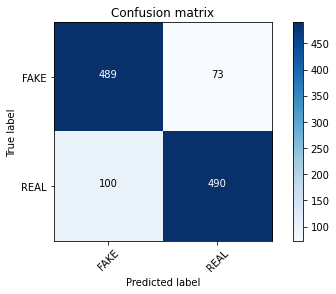

In [35]:
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.f1_score(y_test, pred)
print("f1-score:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

# Passive Aggressive Classifier Algorithm

In [36]:
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier(max_iter=40)

f1-score:   0.827
Confusion matrix, without normalization


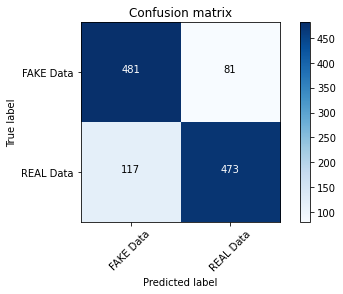

In [37]:
linear_clf.fit(X_train, y_train)
pred = linear_clf.predict(X_test)
score = metrics.f1_score(y_test, pred)
print("f1-score:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

# Multinomial Classifier with Hyperparameter

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [39]:
classifier=MultinomialNB(alpha=0.1)
previous_score=0
for alpha in np.arange(1,2,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(X_train,y_train)
    y_pred=sub_classifier.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    if score > previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

Alpha: 1.0, Score : 0.8498263888888888
Alpha: 1.1, Score : 0.8515625
Alpha: 1.2000000000000002, Score : 0.8524305555555556
Alpha: 1.3000000000000003, Score : 0.8541666666666666
Alpha: 1.4000000000000004, Score : 0.8532986111111112
Alpha: 1.5000000000000004, Score : 0.8524305555555556
Alpha: 1.6000000000000005, Score : 0.8506944444444444
Alpha: 1.7000000000000006, Score : 0.8506944444444444
Alpha: 1.8000000000000007, Score : 0.8498263888888888
Alpha: 1.9000000000000008, Score : 0.8498263888888888


# Logistic Regression

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

f1-score:   0.852
Confusion matrix, without normalization


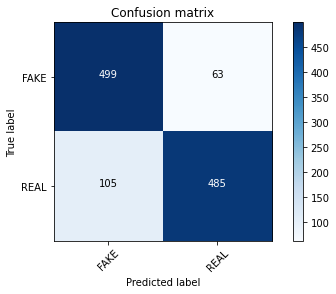

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.f1_score(y_test, pred)
print("f1-score:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

## CatBoost

In [42]:
!pip install -q catboost

     |████████████████████████████████| 76.6 MB 44 kB/s 


In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
from catboost import CatBoostClassifier
classifier = CatBoostClassifier(iterations=1500, learning_rate=0.03, depth=4)

0:	learn: 0.6914146	total: 117ms	remaining: 2m 55s
1:	learn: 0.6891669	total: 163ms	remaining: 2m 1s
2:	learn: 0.6874826	total: 207ms	remaining: 1m 43s
3:	learn: 0.6856174	total: 243ms	remaining: 1m 30s
4:	learn: 0.6841466	total: 269ms	remaining: 1m 20s
5:	learn: 0.6832504	total: 296ms	remaining: 1m 13s
6:	learn: 0.6821805	total: 327ms	remaining: 1m 9s
7:	learn: 0.6809044	total: 355ms	remaining: 1m 6s
8:	learn: 0.6794302	total: 383ms	remaining: 1m 3s
9:	learn: 0.6782012	total: 412ms	remaining: 1m 1s
10:	learn: 0.6771843	total: 456ms	remaining: 1m 1s
11:	learn: 0.6760620	total: 518ms	remaining: 1m 4s
12:	learn: 0.6750187	total: 580ms	remaining: 1m 6s
13:	learn: 0.6740710	total: 636ms	remaining: 1m 7s
14:	learn: 0.6731364	total: 678ms	remaining: 1m 7s
15:	learn: 0.6719646	total: 716ms	remaining: 1m 6s
16:	learn: 0.6713188	total: 749ms	remaining: 1m 5s
17:	learn: 0.6697367	total: 798ms	remaining: 1m 5s
18:	learn: 0.6687745	total: 840ms	remaining: 1m 5s
19:	learn: 0.6675572	total: 866ms	re

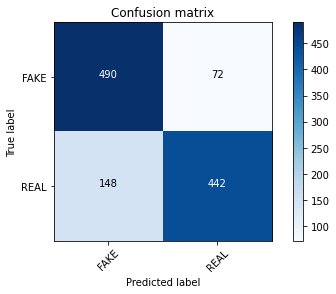

In [45]:
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.f1_score(y_test, pred)
print("f1-score:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

Вывод: Использование stemming токинезатора и LogRegression дают наилучний результат. С лемминг токинезатором результаты по всем моделям хуже.

## Итоги

In [46]:
df_test = pd.read_csv("./dataset/test.tsv", sep='\t')

In [47]:
df_test.head(3)

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,0
1,Ночью под Минском на президентской горе Белара...,0
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,0


In [48]:
df_test.shape

(1000, 2)

In [49]:
test_data = df_test.title.copy().to_numpy()

In [50]:
corpus_train = Stemming_tokenizer.get_tokens(train_data)
corpus_test = Stemming_tokenizer.get_tokens(test_data)

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_v=TfidfVectorizer(max_features=7500,ngram_range=(1,3))
X_train = tfidf_v.fit_transform(corpus_train).toarray()
y_train = df.is_fake.copy().to_numpy()
X_test = tfidf_v.fit_transform(corpus_test).toarray()

In [52]:
X_train.shape, X_test.shape

((5758, 7500), (1000, 7500))

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)

In [54]:
res = df_test.copy()

In [55]:
res.is_fake = pred

In [56]:
res.head()

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,1
1,Ночью под Минском на президентской горе Белара...,0
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,1
3,"Сельская церковь, собравшая рекордно низкое ко...",0
4,Акции Google рухнули после объявления о переза...,1


In [57]:
res.to_csv('predictions.tsv', index=False, sep='\t')